### 필요 Package download

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 현재 gpu를 사용중이면 cuda로 출력됩니다!:
# gpu 변경은 런타임 -> 런타임 유형변경 -> 하드웨어 가속기: GPU로 할 수 있습니다.

print(device)

cuda


## 데이터 부연설명
* 저희가 사용할 dataset은 cifar-10이라는 이름을 가진, 컬러 이미지 데이터 60,000개가 들어있는
dataset입니다. <br>
* 해당 dataset은 총 10개의 class로 나누어져 있으며, 이 task는 각 이미지에 대한 class의 분류 accuracy를 높이는 것이 목적입니다.

### Data Normalize & DataLoader Settting

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:04<00:00, 38881000.25it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


truck  bird horse  bird


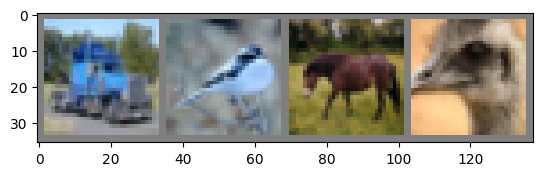

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수
def imshow(img):
    img = img / 2 + 0.5 # 표준화 해제
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.__next__()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
plt.show()

In [5]:
import torch.nn as nn
import torch.nn.functional as F

# 과제 1 model

# ovrtfitting model은 lr=0.0015, gamma를 0.2로 변경함
class MLP_overfit(nn.Module):
    def __init__(self):
        super(MLP_overfit, self).__init__()
        self.fc1 = nn.Linear(784, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512,256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, 64)
        self.fc7 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.fc5(x)
        x = F.relu(x)
        x = self.fc6(x)
        x = F.relu(x)
        x = self.fc7(x)

        return x
    
class MLP_underfit(nn.Module):
    def __init__(self):
        super(MLP_underfit, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Weight Initialization
        torch.nn.init.xavier_normal_(self.fc1.weight.data, gain=1.0)
        torch.nn.init.xavier_normal_(self.fc2.weight.data, gain=1.0)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x
    
# 과제 2 model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # input channels, output channels, kernel size
        self.pool = nn.MaxPool2d(2, 2)  # kernel size, stride, padding = 0 (default)
        self.conv2 = nn.Conv2d(6, 16, 5)
        #아래 부분의 코드를 수정 혹은 추가해주시면 됩니다! (layer를 추가할때는 self.fc'num'=nn.Linear(x,y)의 형태로 추가하시면 됩니다!)
        self.fc1 = nn.Linear(400, 128) # input features, output features
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        #아래 부분에서 코드를 수정하거나 추가하여 forward 함수를 새롭게 지정해주시기 바랍니다!
        #Hint: relu 함수는 출력층을 제외한 모든 층에서 활성화 함수로써 작동되어야 합니다.
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

net = Net()

In [7]:
import torch.optim as optim

#optimizer를 변경하거나 수치를 조정해보는 것도 accuracy를 높이는 데 도움을 줄 수 있습니다!
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [9]:
def eval_eapoch_loss(criterion, optimizer, trainloader, net):
    for epoch in range(10):  # 데이터셋을 n차례 반복하여 학습합니다. 또한 range 속의 숫자도 바꾸어 학습률을 높이는 것도 도움이 될 겁니다!

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # 입력을 받은 후
            inputs, labels = data
            # 변화도(Gradient) 매개변수를 0으로 만든 후
            optimizer.zero_grad()

            # 순전파 + 역전파 + 최적화
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # 통계 출력
            running_loss += loss.item()
            # 2000개의 data를 학습할때마다 loss 출력
            if i % 2000 == 1999:    # % 뒤에 들어갈 숫자의 크기를 조정하여 batch_size를 조정할 수 있습니다! 그리고 i % n == n-1:로 숫자를 맞춰주셔야 한다는 점 잊지 마세요!
                print('[%d, %5d] epoch loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000)) # running_loss 우측의 숫자 역시 윗줄에서 바꾼 batch_size로 바꿔주어야 합니다!
                running_loss = 0.0

    print('Finished Training')

eval_eapoch_loss(criterion=criterion, optimizer=optimizer, trainloader=trainloader, net=net)

[1,  2000] epoch loss: 1.518
[1,  4000] epoch loss: 1.471
[1,  6000] epoch loss: 1.456
[1,  8000] epoch loss: 1.414
[1, 10000] epoch loss: 1.402
[1, 12000] epoch loss: 1.362
[2,  2000] epoch loss: 1.313
[2,  4000] epoch loss: 1.295
[2,  6000] epoch loss: 1.280
[2,  8000] epoch loss: 1.270
[2, 10000] epoch loss: 1.254
[2, 12000] epoch loss: 1.259
[3,  2000] epoch loss: 1.185
[3,  4000] epoch loss: 1.185
[3,  6000] epoch loss: 1.187
[3,  8000] epoch loss: 1.197
[3, 10000] epoch loss: 1.159
[3, 12000] epoch loss: 1.171
[4,  2000] epoch loss: 1.093
[4,  4000] epoch loss: 1.102
[4,  6000] epoch loss: 1.124
[4,  8000] epoch loss: 1.116
[4, 10000] epoch loss: 1.121
[4, 12000] epoch loss: 1.113
[5,  2000] epoch loss: 1.040
[5,  4000] epoch loss: 1.047
[5,  6000] epoch loss: 1.088
[5,  8000] epoch loss: 1.059
[5, 10000] epoch loss: 1.058
[5, 12000] epoch loss: 1.074
[6,  2000] epoch loss: 1.002
[6,  4000] epoch loss: 0.997
[6,  6000] epoch loss: 1.008
[6,  8000] epoch loss: 1.030
[6, 10000] epo

KeyboardInterrupt: 

GroundTruth:    cat  ship  ship plane


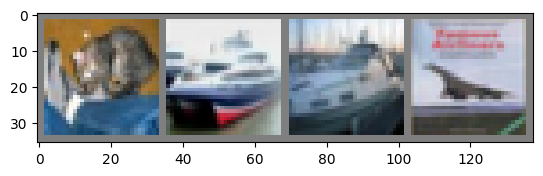

In [10]:

dataiter = iter(testloader)
images, labels = dataiter.__next__()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
plt.show()


In [11]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))


Predicted:   ship  ship   car  ship


In [12]:
def eval_accuracy(testloader, net):
    #과제2에서 accuracy
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

eval_accuracy(testloader=testloader, net=net)

Accuracy of the network on the 10000 test images: 61 %


In [13]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 68 %
Accuracy of   car : 79 %
Accuracy of  bird : 41 %
Accuracy of   cat : 37 %
Accuracy of  deer : 62 %
Accuracy of   dog : 45 %
Accuracy of  frog : 72 %
Accuracy of horse : 71 %
Accuracy of  ship : 71 %
Accuracy of truck : 62 %


출처: https://m.blog.naver.com/ckdgus1433/221406102936의 튜토리얼을 참고하였습니다!

#과제

##1. 실습 파일의 overfitting model의 optimizer, epoch, learning rate 등을 변경하여 실행한 결과와, underfitting의 layer를 2개 이상 추가하여 실행한 결과를 각각 캡처하여 overfit, underfit이라는 이름으로 깃허브에 제출하기.

##2. 과제 파일을 수정하여 Test image에 대한 accuracy를 53% 이상으로 높이고, 모델의 결과에 대한 캡처본과 파일을 모두 깃허브에 제출하기. <br>

Hint: 파일 중간중간에 설명이 있는 부분을 참고하시면 아마 될 겁니다!<br>
(layer 추가, optimizer 변경, learning rate 조정 등...)

##3. MLP model과 기존 ML model의 차이점을 최소 2가지 측면에서 서술하기. <br>
답1: MLP는 Deep Learning의 기본 형태(최소의 inductive bias)로, input, output과 1개 이상의 hidden layer로 구성된 NN 구조dl다. 이와 달리, 기존 ML 모델(regression, DT)는 비교적 단순한 구조를 가지고 있습니다. MLP는 이런 NN 구조를 통해 비선형(XOR) 문제를 효과적으로 처리할 수 있다.
답2: MLP는 Backpropagation 알고리즘을 통해 weight(특정 알고리즘은 bias도)를 학습한다.

##4. Backpropagation이 무엇인지 자신의 언어로 한줄 요약!    <br>
답: Epoch마다 loss function을 참조하여 Chain rule, optimizer를 통해 Gradient descent를 수행함으로써 Neural network의 accuracy가 향상하도록 학습시키는 알고리즘.
